# Exploring Blindingly Fast Alignment

__Objective:__ The ebible corpus contains a number of Bibles which have been partially translated. By comparing all possible pairs of Bibles in varying languages, we would like to determine pairs with a high likelihood of benefitting from further use of translation via DL/NLP methods. These language pairs may already be known to share many commonalities (eg. Spanish and Portuguese), or they may not. We are especially interested in language pairs for which these commonalities are not immediately apparent. Ultimately we would like to determine (or approximate) an unsupervised translation scoring for all $N_C2$ pairs in the ebible corpus.

So far, we can perform statistical machine translation through a custom implementation of IBM1, which appears to be faster than the current SOTA implementation. We then assess the qualities of these translations using a BLEU score. We are assuming that, given a high BLEU score via this unsupervised method, a more rigorous (semi-)supervised approach is worth exploring.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from nltk.translate import IBMModel1
from nltk.translate import Alignment, AlignedSent
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import os
import time

%matplotlib inline

## IBM Model 1 Expectation Maximization:
The pseudocode for IBM Model 1 is laid out below:
```
Input: set of sentence pairs (E_1,F_1), ... (E_n, F_n)
Let transitions T(e|f) be uniform for all unique e in {E_1,...E_n,} and all unique f in {F_1,...,F_n}
while transition probabilities T not converged:
    for all unique e and all unique f, count(e|f) <- 0
    for all unique f, total(f) <- 0
    for all sentence pairs (E_i, F_i):
        for all words p in E_i:
            sentence_total(p) <- 0
            for all words q in F_i:
                sentence_total(p) += T(p|q)
        for all words p in E_i:
            for all words q in F_i:
                count(p|q) += T(p|q) / sentence_total(p)
                total(q) += T(p|q) / sentence_total(p)
    for all unique f:
        for all unique e:
            T(e|f) <- count(e|f) / total(f)
Output: transition probabilities T(e|f) for all unique e, all unique f
```

In [132]:
#Quality-of-life functions go here

def run_translations(source_phrases,trans_dict,prob_thresh=0.0):
    trans_target_phrases = []
    trans_target_log_probs = []
    for phrase in source_phrases:
        trans_phrase = []
        init_log_prob = 0.0 #Operating in log-space to avoid FP arithmetic
        for word in phrase:
            if trans_dict[word][0][0] is None:
                init_log_prob+=np.log(trans_dict[word][0][1])
            elif trans_dict[word][0][1]>prob_thresh:
                trans_phrase.append(trans_dict[word][0][0])
                init_log_prob+=np.log(trans_dict[word][0][1])
        trans_target_phrases.append(trans_phrase)
        trans_target_log_probs.append(init_log_prob)
    return trans_target_phrases, trans_target_log_probs

def read_file_pair(filename_1,filename_2,foldername):
    start_file_1 = open(os.path.join(foldername,filename_1),'r').read().split('\n')
    line_idxs_1 = [i for i in range(len(start_file_1)) if len(start_file_1[i])>0]

    start_file_2 = open(os.path.join(foldername,filename_2),'r').read().split('\n')
    line_idxs_2 = [i for i in range(len(start_file_1)) if len(start_file_2[i])>0]
    line_intersect = np.intersect1d(line_idxs_1,line_idxs_2)

    line_set_1 = [start_file_1[i].lower().replace('.',\
                    '').replace(',','').replace('?','').split(' ') for i in line_intersect]
    line_set_2 = [start_file_2[i].lower().replace('.',\
                    '').replace(',','').replace('?','').split(' ') for i in line_intersect]
    return line_set_1,line_set_2

In [115]:
#A simple example to assess BLEU performance and wall time
german_phrases = [['klein', 'ist', 'das', 'haus'], ['das', 'haus', 'ist', 'ja', 'groß'], \
    ['das', 'buch', 'ist', 'ja', 'klein'], ['ein', 'haus', 'ist', 'klein'], ['das', 'haus'], \
    ['das', 'buch'], ['ein', 'buch'], ['ich', 'fasse', 'das', 'buch', 'zusammen'], ['fasse', 'zusammen']]

english_phrases = [['the', 'house', 'is', 'small'],['the', 'house', 'is', 'big'], \
    ['the', 'book', 'is', 'small'], ['a', 'house', 'is', 'small'], ['the', 'house'], \
    ['the', 'book'], ['a', 'book'], ['i', 'summarize', 'the', 'book'], ['summarize']]

In [50]:
def train_align_NLTK(target_phrases,source_phrases,prob_thresh=0.0):
    als = []
    for i in range(len(target_phrases)):
        als.append(AlignedSent(source_phrases[i],target_phrases[i]))
    ibm1 = IBMModel1(als, len(target_phrases))
    ttable = {}
    for i in dict(ibm1.translation_table).keys():
        ttable[i] = dict(ibm1.translation_table[i])
    trans_dict = {}
    for word in sorted(ttable.keys()):
        w_list = list(ttable[word].keys())
        p_list = np.array([ttable[word][i] for i in w_list])
        p_list /= np.sum(p_list)
        final_assess = sorted(zip(w_list,p_list),key = lambda x: -x[1])
        trans_dict[word]=final_assess
    return trans_dict

trans_dict = train_align_NLTK(english_phrases, german_phrases)
trans_sentences, trans_log_probs = run_translations(german_phrases,trans_dict)
print('BLEU',corpus_bleu([[i] for i in english_phrases], trans_sentences))

BLEU 0.49723872475218195


In [47]:
def train_align(target_phrases, source_phrases, em_iters=25,prob_thresh=0.6):
    target_vocab = sorted(np.unique([word for sentence in target_phrases for word in sentence]))
    t = defaultdict(lambda: defaultdict(lambda: (1.0 / len(target_vocab))))
    for epoch in range(em_iters):
        count_e_given_f = defaultdict(lambda: defaultdict(lambda: 0.0))
        total = defaultdict(lambda: 0.0)
        for idx, (target_sent, source_sent) in enumerate(zip(target_phrases,source_phrases)):
            sentence_total = defaultdict(lambda: 0.0)
            for e_word in source_sent:
                for f_word in target_sent:
                    sentence_total[e_word] += t[e_word][f_word]
            for e_word in source_sent:
                for f_word in target_sent:
                    result = t[e_word][f_word] / sentence_total[e_word]
                    count_e_given_f[e_word][f_word] += result
                    total[f_word] += result
        for e_word, f_words in count_e_given_f.items():
            for f_word in f_words:
                t[e_word][f_word] = count_e_given_f[e_word][f_word] / total[f_word]
    #Final munging, aggregation, and pdf partitioning
    trans_dict = {}
    for word in sorted(t.keys()):
        w_dict = dict(t[word])
        w_list = list(w_dict.keys())
        p_list = np.array([w_dict[i] for i in w_list])
        p_list /= np.sum(p_list) #Normalize probs via partition
        final_assess = sorted(zip(w_list,p_list),key = lambda x: -x[1])
        trans_dict[word]=final_assess
    return trans_dict

start_t = time.time()
trans_dict = train_align(english_phrases, german_phrases)
trans_sentences, trans_log_probs = run_translations(german_phrases,trans_dict)
print('BLEU',corpus_bleu([[i] for i in english_phrases], trans_sentences))

BLEU 0.49723872475218195


In [48]:
start_t = time.time()
all_t_dict = train_align(english_phrases, german_phrases)
print('OUR TIME',time.time()-start_t)

start_t = time.time()
all_t_dict = train_align_NLTK(english_phrases, german_phrases)
print('NLTK TIME',time.time()-start_t)

OUR TIME 0.0017833709716796875
NLTK TIME 0.0012526512145996094


Starting with a real example (aai and aak language codes):

In [134]:
foldername = 'all_data/corpus/' #NOTE: PUT YOUR FOLDER PATH HERE!
line_set_1, line_set_2 = read_file_pair('aai-aai.txt','aak-aak.txt',foldername)


In [67]:
our_train_wallt = []
our_logP = []
our_Cbleu = []
our_Sbleu = []

for i in range(10,201,10):
    start_t = time.time()
    trans_dict = train_align(line_set_1[:i], line_set_2[:i])
    our_train_wallt.append(time.time()-start_t)
    trans_sentences, trans_log_probs = run_translations(line_set_2[:i],trans_dict)
    our_logP.append(trans_log_probs)
    our_Cbleu.append(corpus_bleu([[j] for j in line_set_1[:i]], trans_sentences))
    our_Sbleu.append([sentence_bleu([line_set_1[j]],trans_sentences[j]) for j in range(i)])

nltk_train_wallt = []
nltk_logP = []
nltk_Cbleu = []
nltk_Sbleu = []

for i in range(10,201,10):
    start_t = time.time()
    trans_dict = train_align_NLTK(line_set_1[:i], line_set_2[:i])
    nltk_train_wallt.append(time.time()-start_t)
    trans_sentences, trans_log_probs = run_translations(line_set_2[:i],trans_dict)
    nltk_logP.append(trans_log_probs)
    nltk_Cbleu.append(corpus_bleu([[j] for j in line_set_1[:i]], trans_sentences))
    nltk_Sbleu.append([sentence_bleu([line_set_1[j]],trans_sentences[j]) for j in range(i)])


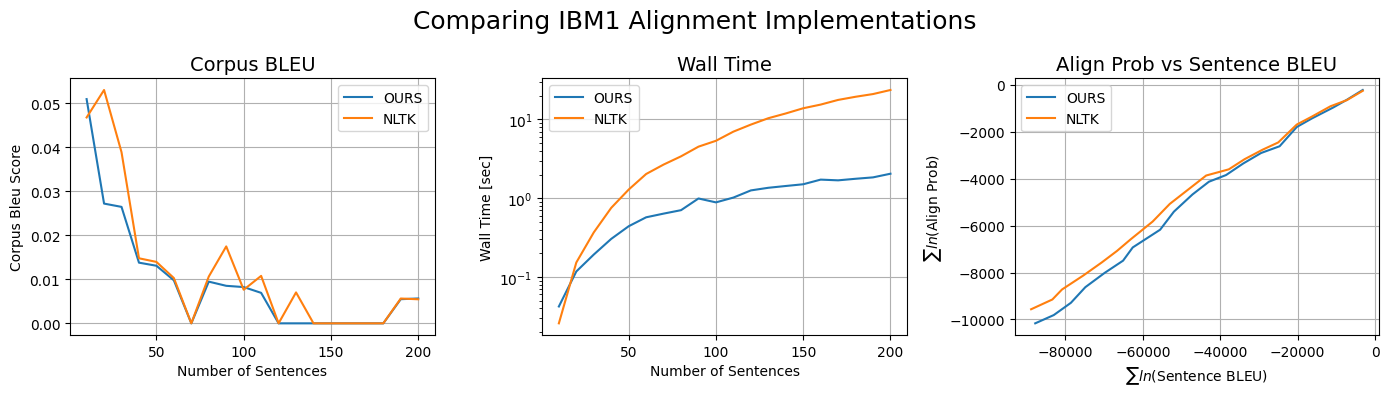

In [129]:
fig, axs = plt.subplots(1,3,figsize=(14,4))
axs[0].plot(range(10,201,10),our_Cbleu,label='OURS')
axs[0].plot(range(10,201,10),nltk_Cbleu,label='NLTK')
axs[0].set_title('Corpus BLEU',fontsize=14)
axs[0].set_xlabel('Number of Sentences')
axs[0].set_ylabel('Corpus Bleu Score')
axs[0].legend()
axs[0].grid()

axs[1].semilogy(range(10,201,10),our_train_wallt,label='OURS')
axs[1].semilogy(range(10,201,10),nltk_train_wallt,label='NLTK')
axs[1].set_title('Wall Time',fontsize=14)
axs[1].set_xlabel('Number of Sentences')
axs[1].set_ylabel('Wall Time [sec]')
axs[1].legend()
axs[1].grid()

axs[2].plot([np.sum(np.log([j for j in i if j!=0])) for i in our_Sbleu],\
            [np.sum(i) for i in our_logP],label='OURS')
axs[2].plot([np.sum(np.log([j for j in i if j!=0])) for i in nltk_Sbleu],\
            [np.sum(i) for i in nltk_logP],label='NLTK')
axs[2].set_title('Align Prob vs Sentence BLEU',fontsize=14)
axs[2].set_xlabel('$\sum ln$(Sentence BLEU)')
axs[2].set_ylabel('$\sum ln$(Align Prob)')
axs[2].legend()
axs[2].grid()

fig.suptitle('Comparing IBM1 Alignment Implementations',fontsize=18)
plt.tight_layout()
plt.show()

In [137]:
foldername = 'ebible/code/python/all_data/corpus/' #NOTE: PUT YOUR FOLDER PATH HERE!
lang_codes = [i.split('-')[0] for i in sorted(os.listdir(foldername))[:10]]
Cbleu_all_pairs = []
for i in sorted(os.listdir(foldername))[:10]:
    Cbleu_sub = []
    for j in sorted(os.listdir(foldername))[:10]:
        if j!=i:
            l1, l2 = read_file_pair(i,j,foldername)
            trans_dict = train_align(l1, l2)
            trans_sentences, trans_log_probs = run_translations(l2,trans_dict)
            Cbleu_sub.append(corpus_bleu([[j] for j in l1], trans_sentences))
        else:
            Cbleu_sub.append(0)
    Cbleu_all_pairs.append(Cbleu_sub)

/home/meschw04/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/meschw04/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


/tmp/ipykernel_246534/1696427442.py:2: RuntimeWarning: divide by zero encountered in log
  log_Cbleu_all_pairs = np.log(np.array(Cbleu_all_pairs))


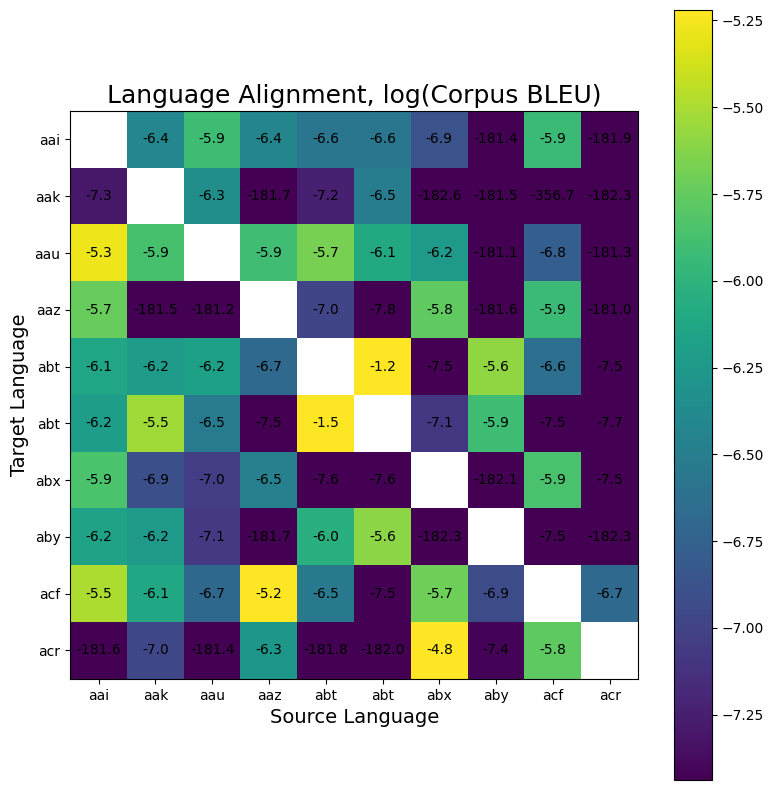

In [187]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
log_Cbleu_all_pairs = np.log(np.array(Cbleu_all_pairs))
log_Cbleu_flat = log_Cbleu_all_pairs.flatten()
log_Cbleu_flat = [i for i in log_Cbleu_flat[~np.isinf(log_Cbleu_flat)] if i>-50]

im = ax.imshow(log_Cbleu_all_pairs,\
        vmin=np.average(log_Cbleu_flat)-np.std(log_Cbleu_flat),\
        vmax=np.average(log_Cbleu_flat)+np.std(log_Cbleu_flat))
ax.set_xticks(range(len(lang_codes)))
ax.set_yticks(range(len(lang_codes)))
ax.set_xticklabels(lang_codes)
ax.set_yticklabels(lang_codes)
ax.set_title('Language Alignment, log(Corpus BLEU)',fontsize=18)
for i in range(len(log_Cbleu_all_pairs)):
    for j in range(len(log_Cbleu_all_pairs)):
        if i!=j:
             ax.text(j,i,round(log_Cbleu_all_pairs[i,j],1),ha='center',va='center',color='k')
ax.set_xlabel('Source Language',fontsize=14)
ax.set_ylabel('Target Language',fontsize=14)
plt.colorbar(im,ax=ax)
plt.tight_layout()
plt.show()

How confident am I that anything can be inferred from these incredibly low corpus BLEU scores? Maybe an average sentence BLEU would beat out a corpus BLEU, and be a more fair representation? Maybe analyzing high-probability matches in translation dictionaries would be a good place to look as well in terms of an unsupervised confidence assessment? Additional supervision (in some form, not sure what) would be nice, but probably too labor-intensive for what boils down to a time-saving effort. Fine-tuning NLLB on high-scoring language pairs is another (more computationally costly) avenue that I believe that we will want to explore also.

## *EXPERIMENT SANDBOX*

*Idea:* I wrote an implementation that uses ndarrays instead of default dict. Instead of key-value lookups and updates, just sum over the sparse matrices. The probem is that the matrices are both very sparse and very large, and therefore eat up a lot of RAM. While certainly having the same computational complexity ($O(n^3)$?), the matrix operations also take a lot of time to execute, so wall time is through the roof.

I think that the way to address this is to use the `scipy.sparse` matrix library, and rely on CSR-type sparse matrices, or something of the sort. The problem with doing so is that, by creating a sparse matrix object, we limit the algebraic operations we are able to carry out and change the computational complexity of lookups/replacements in potentially unintended and expensive ways. However, if it can be done (and maybe even JIT-ed?), then I am fairly confident that it would be even faster. Maybe much faster.

In [114]:
import time
from jax.experimental import sparse
import jax.numpy as jnp
def train_align_NUMPY(target_phrases, source_phrases):
    #NOTE: If you run this right now on a real example, the empty arrays will overwhelm RAM and swap.
    #The code works on small examples, but a sparse implementation is required.
    '''
    This is a numpy-driven implementation of IBM1 fast alignment.
    '''
    #Find all unique words
    source_vocab = sorted(np.unique([word for sentence in source_phrases for word in sentence]))
    target_vocab = sorted(np.unique([word for sentence in target_phrases for word in sentence]))
    #Tokenize phrases
    source_phrases = [[source_vocab.index(j) for j in i] for i in source_phrases]
    target_phrases = [[target_vocab.index(j) for j in i] for i in target_phrases]
    #Pre-compute counts of uniques characters within sentences
    ep_uniques = []
    ep_counts = []
    gp_uniques = []
    gp_counts = []
    for p in source_phrases:
        un, ct = np.unique(p,return_counts=True)
        ep_uniques.append(un)
        ep_counts.append(ct)
    for p in target_phrases:
        un, ct = np.unique(p,return_counts=True)
        gp_uniques.append(un)
        gp_counts.append(ct)
    #Initialize transition matrix as uniform dist.
    t = np.ones([len(source_vocab),len(target_vocab)])*(1./len(target_vocab))
    #Begin EM Algo
    for epoch in range(25):
        count_e_given_f = np.zeros([len(source_vocab),len(target_vocab)])
        total = np.zeros(len(target_vocab))
        for idx in range(len(target_phrases)):
            unique_e = ep_uniques[idx]
            count_e = ep_counts[idx]
            unique_f = gp_uniques[idx]
            count_f = gp_counts[idx]
            #Compute Normalization
            sentence_total = np.zeros(len(source_vocab))
            sentence_total[unique_e] += count_e*np.sum(count_f.reshape(1,-1)*t[:,unique_f][unique_e],axis=1)
            #Collect Counts
            result = np.divide(t[:,unique_f], sentence_total.reshape(-1,1),\
                out=np.zeros_like(t[:,unique_f]), where=sentence_total.reshape(-1,1)!=0)
            result[unique_e] = count_e.reshape(-1,1)*count_f*result[unique_e]
            count_e_given_f[:,unique_f] += result
            total[unique_f] += np.sum(result,axis=0)
        #Estimate Probabilities
        t = count_e_given_f / total
    #Normalize w.r.t. partition
    t /= np.sum(t,axis=0)
    return t

english_vocab = sorted(np.unique([word for sentence in english_phrases for word in sentence]))
german_vocab = sorted(np.unique([word for sentence in german_phrases for word in sentence]))
    
start_t = time.time()
all_t = train_align_NUMPY(german_phrases, english_phrases)
#for i in range(len(english_vocab)):
#    print(english_vocab[i],list(zip(german_vocab,all_t[i].tolist())))

In [130]:
import time
from jax.experimental import sparse
import jax.numpy as jnp
from scipy.sparse import *
def train_model_SPARSE(target_phrases, source_phrases):
    raise NotImplementedError
    #Still currently struggling with sparse implementation.
    '''
    This is a numpy-driven implementation of IBM1 fast alignment.
    '''
    #Find all unique words
    source_vocab = sorted(np.unique([word for sentence in source_phrases for word in sentence]))
    target_vocab = sorted(np.unique([word for sentence in target_phrases for word in sentence]))
    #Tokenize phrases
    source_phrases = [[source_vocab.index(j) for j in i] for i in source_phrases]
    target_phrases = [[target_vocab.index(j) for j in i] for i in target_phrases]
    #Pre-compute counts of uniques characters within sentences
    ep_uniques = []
    ep_counts = []
    gp_uniques = []
    gp_counts = []
    for p in source_phrases:
        un, ct = np.unique(p,return_counts=True)
        ep_uniques.append(un)
        ep_counts.append(ct)
    for p in target_phrases:
        un, ct = np.unique(p,return_counts=True)
        gp_uniques.append(un)
        gp_counts.append(ct)
    #Initialize transition matrix as uniform dist.
    t = np.ones([len(source_vocab),len(target_vocab)])*(1./len(target_vocab))
    #Begin EM Algo
    for epoch in range(25):
        count_e_given_f = csr_array((len(source_vocab),len(target_vocab)),dtype=np.float64) #IS CSR CORRECT?
        total = np.zeros(len(target_vocab))
        for idx in range(len(target_phrases)):
            unique_e = ep_uniques[idx]
            count_e = ep_counts[idx]
            unique_f = gp_uniques[idx]
            count_f = gp_counts[idx]
            #Compute Normalization
            sentence_total = np.zeros(len(source_vocab))
            sentence_total[unique_e] += count_e*np.sum(count_f.reshape(1,-1)*t[:,unique_f][unique_e],axis=1)
            #Collect Counts
            result = np.divide(t[:,unique_f], sentence_total.reshape(-1,1),\
                out=np.zeros_like(t[:,unique_f]), where=sentence_total.reshape(-1,1)!=0)
            result[unique_e] = count_e.reshape(-1,1)*count_f*result[unique_e]
            count_e_given_f[:,unique_f] += result
            total[unique_f] += np.sum(result,axis=0)
        #Estimate Probabilities
        t = count_e_given_f / total
    #Normalize w.r.t. partition
    t /= np.sum(t,axis=0)
    return t

*Idea:* A bandit-based approach for determining alignment potential. Use Thompson Sampling (potentially with a Bayesian prior constructed from language dendrogram based clustering?) or a Lipschitz-style bandit? See Slivikins 2019 text.

*Idea:* In an incremental approach, ensure that EM-optimized transition dictionaries from earlier cycles are fed back in alongside new and old phrases. Consider studying how effectively we are fine-tuning transition dictionaries with further EM optimization on newer phrases, and how this might govern early stopping, leading to further speed-ups.

*TODO:* Measure the number of epochs required for EM optimization to equilibrate (i.e. probabilities in the transition dictionary no longer vary by statistically significant quantities). Is 25 epochs sufficient? Is it overkill?